In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

%config InlineBackend.figure_format = 'retina'
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

if os.path.exists('deer.jpg'):
    print('deer.jpg exists')

deer.jpg exists


"Image preprocessing"

In [4]:
img = torchvision.io.read_image("deer.jpg")
print(img.shape)

torch.Size([3, 427, 640])


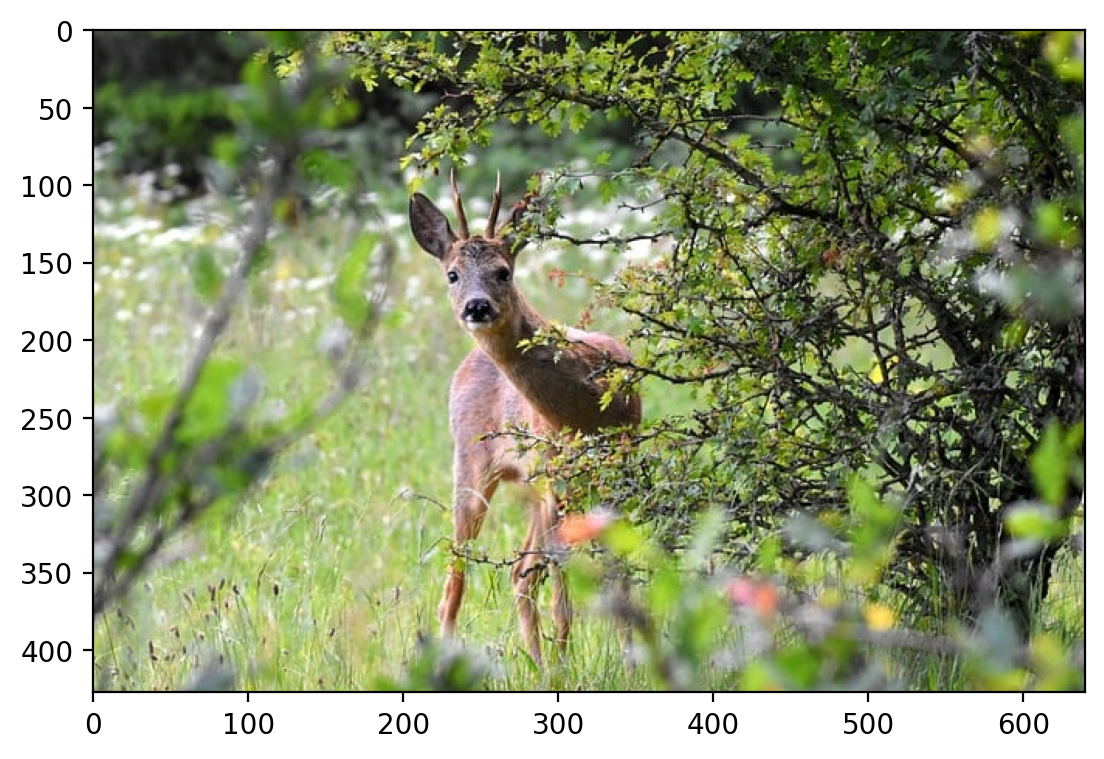

In [5]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [7]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [11]:
scaled_img = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
scaled_img.shape

scaled_img = torch.tensor(scaled_img)
scaled_img = scaled_img.to(device)
scaled_img.shape

torch.Size([3, 427, 640])

In [17]:
crop = torchvision.transforms.functional.crop(scaled_img.cpu(), 000, 000, 400, 500)
crop = crop.to(device)

print(crop.shape)
crop.max()

torch.Size([3, 400, 500])


tensor(1., dtype=torch.float64)

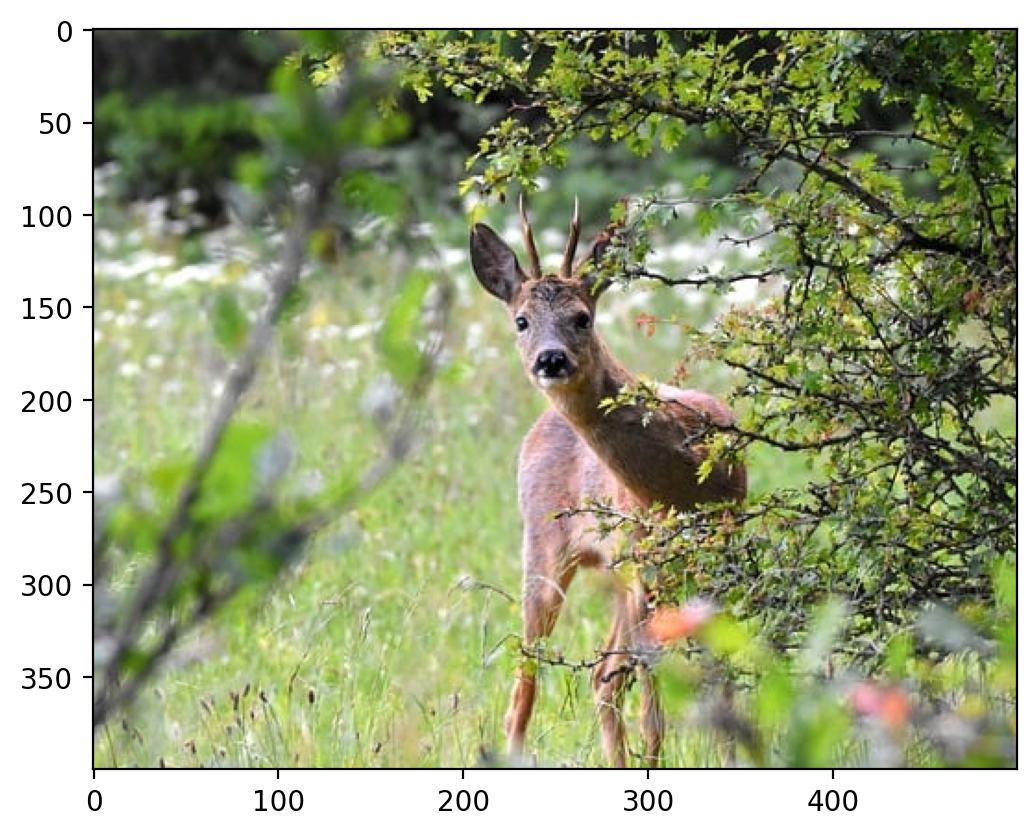

In [15]:
plt.imshow(rearrange(crop, 'c h w -> h w c').numpy())


In [20]:
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 400 500


In [21]:
num_channels, height, width = 2, 3, 4

    
# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

In [22]:
X.shape

torch.Size([12, 2])

In [38]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)
    

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [39]:
deer_X, deer_Y = create_coordinate_map(crop)

deer_X.shape, deer_Y.shape

(torch.Size([200000, 2]), torch.Size([200000, 3]))

In [40]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(deer_X.cpu())
# Scale the X coordinates
deer_X_scaled = scaler_X.transform(deer_X.cpu())
# Move the scaled X coordinates to the GPU
deer_X_scaled = torch.tensor(deer_X_scaled).to(device)
# Convert the scaled X coordinates to float32
deer_X_scaled = deer_X_scaled.float()

In [28]:
#training part
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()


#Linear regression model

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)
    



def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)
    




def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("on")
    
    


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

    return outputs 

In [29]:
#using 1000 features
X_rff = create_rff_features(deer_X_scaled,10000, 0.02)



In [30]:
X_rff.shape

torch.Size([200000, 10000])

In [31]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, deer_Y, 1000)

Epoch 0 loss: 0.291046
Epoch 100 loss: 0.024614
Epoch 200 loss: 0.011440
Epoch 300 loss: 0.010388
Epoch 400 loss: 0.010229
Epoch 500 loss: 0.010184
Epoch 600 loss: 0.010160
Epoch 700 loss: 0.010143
Epoch 800 loss: 0.010130
Epoch 900 loss: 0.010119


0.010110263712704182

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03647027..1.124805].


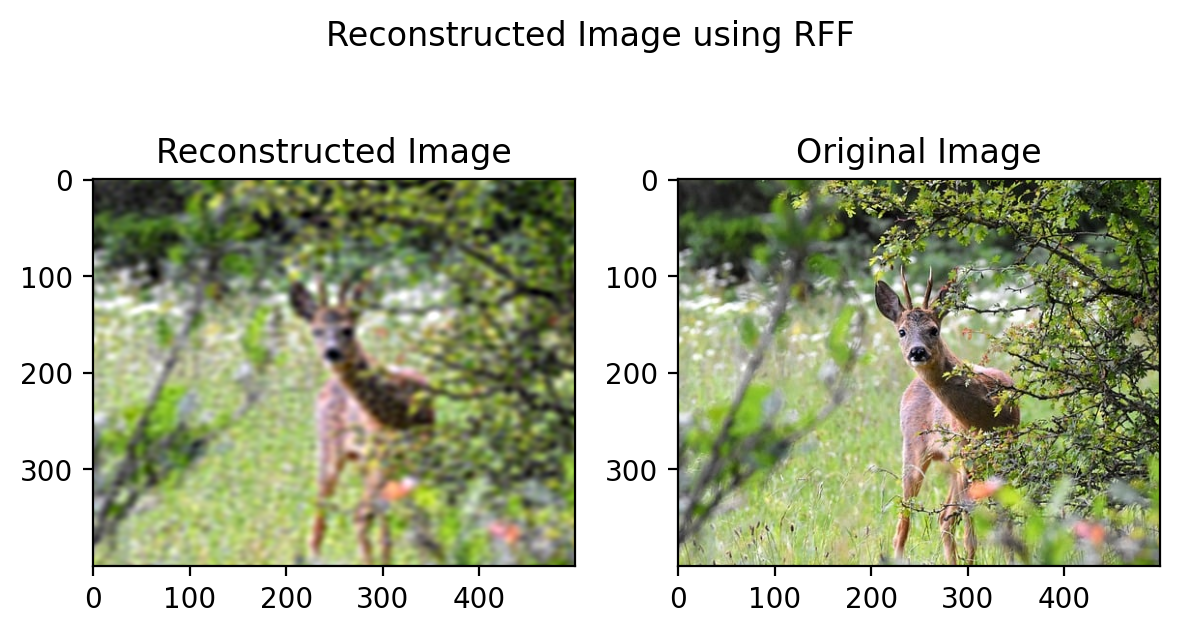

In [32]:
reconstructed_image = plot_reconstructed_and_original_image(crop, net, X_rff,title="Reconstructed Image using RFF")

In [33]:
def cal_rmse(original_img, reconstructed_img):
    # Convert tensors to NumPy arrays and move to CPU if needed
    original_image = original_img.cpu().numpy()
    reconstructed_image = reconstructed_img.cpu().numpy()

    # Compute RMSE
    mse = np.mean((original_image - reconstructed_image) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def cal_psnr(original_img, reconstructed_img):
    rmse = cal_rmse(original_img, reconstructed_img)

    max_pixel = 1.0  
    psnr = 20 * np.log10(max_pixel / rmse)
    return psnr


RMSE

In [35]:
reconstructed_image = reconstructed_image.permute(2, 0, 1)
cal_rmse(crop, reconstructed_image)


0.10054939085234904

PSNR

In [37]:
cal_psnr(crop, reconstructed_image)

19.952411121984234